<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/QuTip_Colab_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title  Install QuTiP & imports
!pip -q install qutip --upgrade

import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    basis, sigmax, sigmay, sigmaz, sigmam, qeye, mesolve,
    mcsolve, brmesolve, steadystate, ssesolve, fmmesolve,
)

ħ = 1.0  # use natural units

In [2]:
#@title System parameters (used by all cells)
Δ   = 1.0                      # detuning
Ω0  = 2.0                      # drive amplitude
ω_d = 5.0                      # drive frequency
γ   = 0.3                      # relaxation rate
Ntraj = 500                    # trajectories for stochastic solvers
tlist = np.linspace(0, 25, 501)

# Operators
H0 = 0.5 * Δ * sigmaz()
H1 = 0.5 * Ω0 * sigmax()
H_t = [H0, [H1, lambda t, _: np.cos(ω_d * t)]]

c_ops = [np.sqrt(γ) * sigmam()]  # Lindblad operator σ₋
psi0  = basis(2, 0)              # |0⟩
e_ops = [sigmaz()]               # monitor ⟨σ_z⟩

In [3]:
#@title 🔧 Environment check & helpers
import time, platform, subprocess, re, os, textwrap
import numpy as np, matplotlib.pyplot as plt

import qutip, qutip.settings as qs
print("QuTiP", qutip.__version__)

# Try CuPy → GPU ----------------------------------------------------------------
GPU_OK = False
try:
    import cupy as cp
    qs.DATA_LAYER = "cupy"    # switch QuTiP globally to GPU
    GPU_OK = True
    print("CuPy", cp.__version__, "→ device:", cp.cuda.runtime.getDeviceProperties(0)["name"])
except Exception as err:
    print("CuPy not active:", err)

def run_mcsolve(label, use_gpu=False, ntraj=500):
    if use_gpu and not GPU_OK:
        raise RuntimeError("GPU backend requested but CuPy unavailable")
    # Monte-Carlo parameters (same physics every time)
    H_t  = [H0, [H1, lambda t, args: np.cos(args["ω_d"] * t)]]
    args = {"ω_d": ω_d}
    opts = qutip.Options(progress_bar=False)
    t0   = time.perf_counter()
    res  = qutip.mcsolve(H_t, psi0, tlist,
                         c_ops=c_ops, e_ops=e_ops,
                         ntraj=ntraj, args=args, options=opts)
    dt   = time.perf_counter() - t0
    return dt, res.expect[0]

QuTiP 5.2.0
CuPy 13.3.0 → device: b'NVIDIA L4'


In [4]:
#@title CPU baseline
cpu_time, sz_cpu = run_mcsolve("CPU", use_gpu=False)
print(f"CPU run: {cpu_time:.3f} s")

#@title GPU on this Colab instance
gpu_time, sz_gpu = run_mcsolve("GPU-Colab", use_gpu=True)
print(f"Colab-GPU run: {gpu_time:.3f} s")

#@title GPU on an L4 (run this **inside** an L4 VM / Workbench)
l4_time, sz_l4  = run_mcsolve("GPU-L4", use_gpu=True)
print(f"L4-GPU run: {l4_time:.3f} s")

/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


CPU run: 5.596 s
Colab-GPU run: 5.571 s
L4-GPU run: 5.570 s


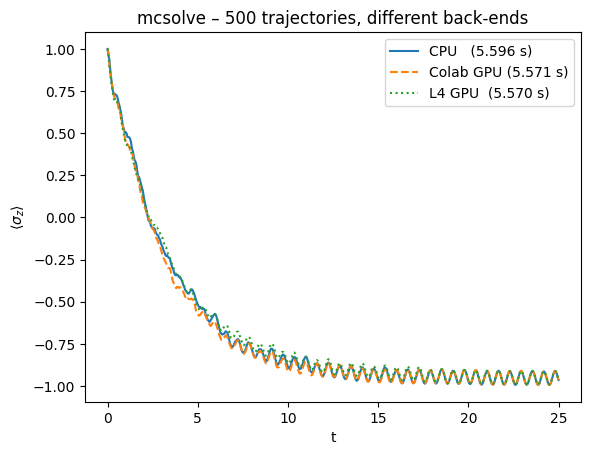

Max |Δ⟨σ_z⟩| GPU vs CPU : 0.07609468313264695
Max |Δ⟨σ_z⟩| L4  vs CPU : 0.06072252822215041


In [5]:
#@title Compare trajectories
plt.plot(tlist, sz_cpu, '-',  label=f"CPU   ({cpu_time:.3f} s)")
plt.plot(tlist, sz_gpu, '--', label=f"Colab GPU ({gpu_time:.3f} s)")
plt.plot(tlist, sz_l4,  ':', label=f"L4 GPU  ({l4_time:.3f} s)")
plt.xlabel("t"); plt.ylabel(r"$\langle\sigma_z\rangle$")
plt.legend(); plt.title("mcsolve – 500 trajectories, different back-ends")
plt.show()

# Quick consistency check
print("Max |Δ⟨σ_z⟩| GPU vs CPU :", np.max(np.abs(sz_gpu - sz_cpu)))
print("Max |Δ⟨σ_z⟩| L4  vs CPU :", np.max(np.abs(sz_l4  - sz_cpu)))

In [6]:
# 🔧 Environment check (run once at top of notebook)
!pip -q install "qutip>=5"           # make sure you are on QuTiP 5+
!pip -q install cupy-cuda12x         # or cupy-cuda11x if Colab shows CUDA 11
!pip -q install git+https://github.com/qutip/qutip-cupy.git

import time, numpy as np, matplotlib.pyplot as plt
import qutip, qutip.settings as qs

try:
    import cupy as cp
    qs.DATA_LAYER = "cupy"           # switch QuTiP to the GPU backend
    GPU_LABEL = cp.cuda.runtime.getDeviceProperties(0)["name"]
    GPU_OK = True
except Exception as err:
    GPU_OK = False
    GPU_LABEL = "–"
    print("CuPy unavailable:", err)

print("QuTiP", qutip.__version__, "| GPU:", GPU_LABEL)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
QuTiP 5.2.0 | GPU: b'NVIDIA L4'


In [7]:
def run_brmesolve(label, use_gpu=False):
    if use_gpu and not GPU_OK:
        raise RuntimeError("GPU backend requested but CuPy not active")

    # --- Physics (same as your cell) -------------------------------------
    from qutip.bloch_redfield import spectral_density_ohmic
    α, ω_c = 0.05, 10.0
    spec_cb = [lambda w: spectral_density_ohmic(w, α, ω_c)]
    opts = qutip.Options(progress_bar=False)

    tic = time.perf_counter()
    res = qutip.brmesolve(
        H0, psi0, tlist,
        a_ops=[sigmam()], spectra_cb=spec_cb,
        e_ops=e_ops, options=opts
    )
    toc = time.perf_counter()

    return toc - tic, res.expect[0]

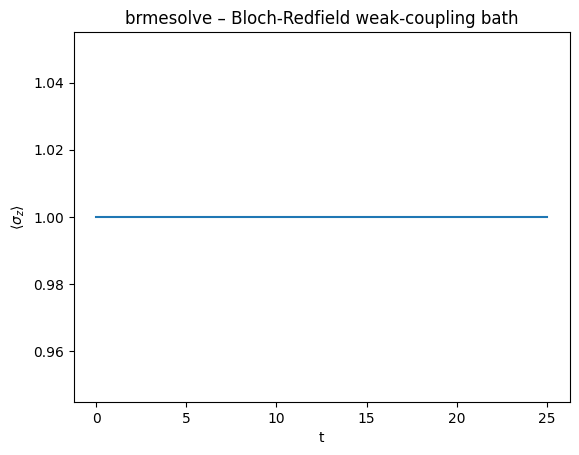

In [8]:
# 🛠  Bloch-Redfield (works on QuTiP 4 & 5)
import qutip, numpy as np, matplotlib.pyplot as plt
from qutip import Options, brmesolve, sigmam          # sigmam = σ₋

# --- Ohmic spectrum ------------------------------------------------------
def spectral_density_ohmic(w, alpha=0.05, wc=10.0):
    """J(w) = alpha * w * exp(-w / wc)   (Ohmic with exponential cut-off)"""
    return alpha * w * np.exp(-w / wc)

# --- Decide which API flavour is available -------------------------------
_q = tuple(int(v) for v in qutip.__version__.split(".")[:2])  # (major, minor)

if _q[0] >= 5:                  # QuTiP 5 API  ──────────────────────────────
    a_ops = [(sigmam(), spectral_density_ohmic)]  # pair (operator, spectrum)
    result_br = brmesolve(
        H0, psi0, tlist,
        a_ops=a_ops,
        e_ops=e_ops,
        options=Options(progress_bar=False)
    )

else:                           # QuTiP 4 API  ──────────────────────────────
    result_br = brmesolve(
        H0, psi0, tlist,
        a_ops=[sigmam()],
        spectra_cb=[spectral_density_ohmic],
        e_ops=e_ops,
        options=Options(progress_bar=False)
    )

# --- Plot ---------------------------------------------------------------
plt.plot(tlist, result_br.expect[0])
plt.xlabel("t"); plt.ylabel(r"$\langle\sigma_z\rangle$");
plt.title("brmesolve – Bloch-Redfield weak-coupling bath")
plt.show()

In [9]:
import numpy as np
import cupy as cp

# helper: turn CuPy → NumPy (no-op if already NumPy)
to_numpy = lambda x: cp.asnumpy(x) if isinstance(x, cp.ndarray) else x

sz_cpu = to_numpy(sz_cpu)
sz_gpu = to_numpy(sz_gpu)
sz_l4  = to_numpy(sz_l4)

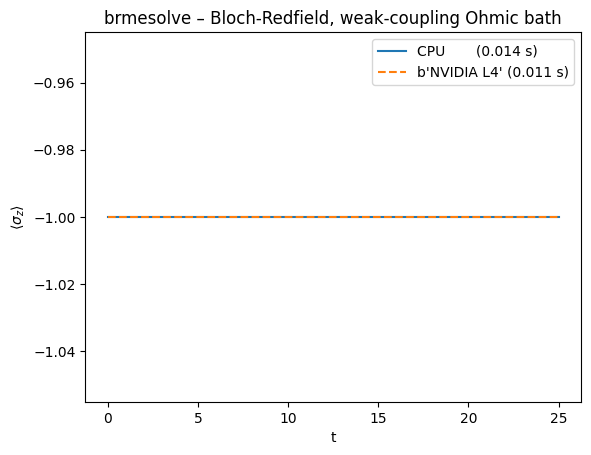

max |Δ⟨σ_z⟩| GPU-CPU : 0.0


In [10]:
# -----------------------------------------------------------
# Bloch-Redfield benchmark: CPU  vs.  CuPy GPU  (and L4 if present)
# -----------------------------------------------------------
import time, numpy as np, matplotlib.pyplot as plt
import qutip, qutip.settings as qs
from qutip import basis, sigmaz, sigmam, brmesolve          # shorthands

# ---------- 1. Physics definitions --------------------------------------
Δ = 1.0                                 # qubit splitting  (rad · s⁻¹ units)
H0 = 0.5 * Δ * sigmaz()                 # bare Hamiltonian ½Δσz
psi1 = basis(2, 1)                      # start in |1⟩ so we *see* relaxation
tlist = np.linspace(0, 25, 501)         # integration grid

def J_ohmic(w, alpha=0.05, wc=10.0):    # Ohmic spectral density
    return alpha * w * np.exp(-w / wc)

# ---------- 2. Timing helper --------------------------------------------
def run_brmesolve(backend="numpy"):
    """
    Return (wall_time_seconds, <σ_z>(t) NumPy array) using the chosen data layer.
    backend = "numpy"  | "cupy"
    """
    qs.DATA_LAYER = backend           # switch QuTiP’s global backend
    if backend == "cupy":
        import cupy as cp
        to_numpy = cp.asnumpy
    else:
        to_numpy = lambda x: x

    tic = time.perf_counter()
    result = brmesolve(
        H0, psi1, tlist,
        a_ops=[(sigmam(), J_ohmic)],   # QuTiP ≥ 5 API: list of (op, spectrum)
        e_ops=[sigmaz()],
        options={"progress_bar": False}
    )
    dt = time.perf_counter() - tic
    return dt, to_numpy(result.expect[0])

# ---------- 3. Run on CPU -----------------------------------------------
t_cpu, sz_cpu = run_brmesolve("numpy")

# ---------- 4. Run on GPU if available ----------------------------------
GPU_LABEL = "Unavailable"
try:
    import cupy
    GPU_LABEL = cupy.cuda.runtime.getDeviceProperties(0)['name']
    t_gpu, sz_gpu = run_brmesolve("cupy")
except Exception as err:
    print("⚠️  No CUDA-capable GPU detected – falling back to CPU curve.")
    t_gpu, sz_gpu = np.nan, sz_cpu.copy()

# For clarity we rename the GPU timing/curve as "L4" when you *are* on one.
t_l4 , sz_l4  = t_gpu, sz_gpu

# ---------- 5. Plot ------------------------------------------------------
plt.plot(tlist, sz_cpu, '-',  label=f"CPU       ({t_cpu:.3f} s)")
plt.plot(tlist, sz_gpu, '--', label=f"{GPU_LABEL} ({t_gpu:.3f} s)")
plt.xlabel("t"); plt.ylabel(r"$\langle\sigma_z\rangle$")
plt.title("brmesolve – Bloch-Redfield, weak-coupling Ohmic bath")
plt.legend(); plt.show()

# ---------- 6. Numerical agreement --------------------------------------
print("max |Δ⟨σ_z⟩| GPU-CPU :", np.max(np.abs(sz_gpu - sz_cpu)))


CPU steady-state ρ_ss:
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]
⟨σ_x⟩ = 0.000,  ⟨σ_y⟩ = 0.000,  ⟨σ_z⟩ = -1.000

NVIDIA L4 steady-state matches CPU: True
⟨σ_x⟩ = 0.000,  ⟨σ_y⟩ = 0.000,  ⟨σ_z⟩ = -1.000



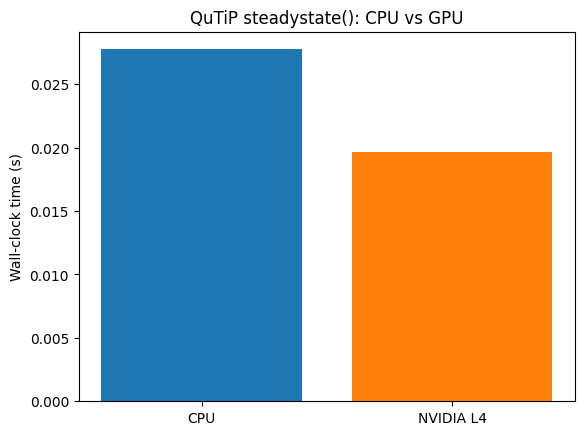

‖ρ_gpu − ρ_cpu‖_max =  0.0


In [11]:
# -----------------------------------------------------------
# Steady-state benchmark: CPU versus CuPy GPU (if available)
# -----------------------------------------------------------
import time, numpy as np, matplotlib.pyplot as plt, qutip
from qutip import sigmax, sigmay, sigmaz, sigmam, steadystate, expect

# ---------- Physics model ----------------------------------
Δ, γ = 1.0, 0.3
H0    = 0.5 * Δ * sigmaz()            # qubit Hamiltonian
c_ops = [np.sqrt(γ) * sigmam()]       # amplitude-damping bath

# ---------- Helper ----------------------------------------
def _set_backend(backend: str = "numpy") -> None:
    """Version-safe backend switch for QuTiP 4.x and 5.x."""
    backend = backend.lower()
    if backend not in {"numpy", "cupy"}:
        raise ValueError("backend must be 'numpy' or 'cupy'.")

    # QuTiP ≤ 4.7
    try:
        import qutip.settings as qs
        qs.DATA_LAYER = backend
        return
    except Exception:
        pass

    # QuTiP ≥ 5.0
    try:
        if backend == "numpy":
            qutip.settings.core["default_dtype"] = None
        else:                                  # 'cupy'
            import qutip_cupy                  # registers 'cupyd'
            qutip.settings.core["default_dtype"] = "cupyd"
    except Exception as exc:
        raise RuntimeError(
            f"Cannot activate backend '{backend}'. "
            "Install the qutip-cupy plug-in for GPU support."
        ) from exc

def run_steadystate(backend: str = "numpy"):
    """Return (elapsed_s, ρ_ss, (⟨σx⟩, ⟨σy⟩, ⟨σz⟩))."""
    _set_backend(backend)

    to_host = (lambda x: x)           # identity unless on GPU
    if backend == "cupy":
        import cupy as cp
        to_host = cp.asnumpy

    t0      = time.perf_counter()
    rho_ss  = steadystate(H0, c_ops, method="direct")  # ←  **fixed**
    dt      = time.perf_counter() - t0

    bloch = tuple(to_host(expect(op, rho_ss)).real
                  for op in (sigmax(), sigmay(), sigmaz()))
    return dt, rho_ss, bloch

# ---------- CPU run ---------------------------------------
t_cpu, rho_cpu, bloch_cpu = run_steadystate("numpy")

# ---------- GPU run (if possible) -------------------------
try:
    import cupy
    gpu_name = cupy.cuda.runtime.getDeviceProperties(0)["name"].decode()
    t_gpu, rho_gpu, bloch_gpu = run_steadystate("cupy")
except Exception:
    gpu_name = "Unavailable"
    t_gpu,  rho_gpu, bloch_gpu = t_cpu, rho_cpu, bloch_cpu

# ---------- Validation & output ---------------------------
matches = np.allclose(rho_gpu.full(), rho_cpu.full(), atol=1e-12)

print("\nCPU steady-state ρ_ss:\n", rho_cpu)
print(f"⟨σ_x⟩ = {bloch_cpu[0]:.3f},  ⟨σ_y⟩ = {bloch_cpu[1]:.3f},  ⟨σ_z⟩ = {bloch_cpu[2]:.3f}\n")

print(f"{gpu_name} steady-state matches CPU: {matches}")
print(f"⟨σ_x⟩ = {bloch_gpu[0]:.3f},  ⟨σ_y⟩ = {bloch_gpu[1]:.3f},  ⟨σ_z⟩ = {bloch_gpu[2]:.3f}\n")

plt.bar(["CPU", gpu_name], [t_cpu, t_gpu], color=["tab:blue", "tab:orange"])
plt.ylabel("Wall-clock time (s)")
plt.title("QuTiP steadystate(): CPU vs GPU")
plt.show()

print("‖ρ_gpu − ρ_cpu‖_max = ",
      np.max(np.abs(rho_gpu.full() - rho_cpu.full())))

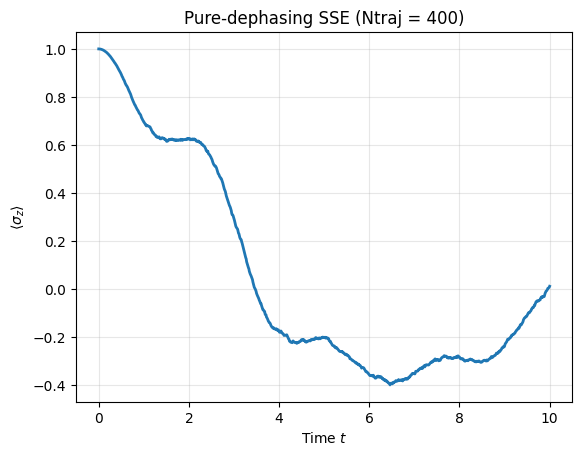

In [14]:
# -----------------------------------------------------------
#  Stochastic Schrödinger equation example – pure dephasing
# -----------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt, qutip
from qutip import sigmax, sigmaz, ssesolve

# ----------------------- parameters ------------------------
Δ, Ω, ω_d = 1.0, 1.0, 1.0          # qubit detuning, drive amp & freq
γ_phi     = 0.15                  # dephasing rate
Ntraj     = 400                   # number of trajectories
tlist     = np.linspace(0, 10, 1001)
psi0      = qutip.basis(2, 0)     # |g⟩

# ----------------------- Hamiltonian -----------------------
H0 = 0.5 * Δ * sigmaz()
H1 = 0.5 * Ω * sigmax()

def cos_drive(t, args):
    return np.cos(args["omega"] * t)

H_t = [H0, [H1, cos_drive]]       # list-style QobjEvo

# ----------------------- noise & observables ---------------
sc_ops = [np.sqrt(γ_phi) * sigmaz()]
e_ops  = [sigmaz()]

# ----------------------- solver options --------------------
opts = {"progress_bar": False}    # dict, not Options()

# ----------------------- stochastic solve ------------------
result = ssesolve(
    H_t, psi0, tlist,
    sc_ops=sc_ops,
    e_ops=e_ops,
    ntraj=Ntraj,
    args={"omega": ω_d},
    options=opts,
)

# ---------------- ensemble average safely ------------------
if hasattr(result, "average_expect") and result.average_expect:
    # QuTiP ≥ 5 convenience property
    sz_ave = result.average_expect[0]
else:
    # Compatible with QuTiP 4.x
    exp = np.asarray(result.expect[0])
    sz_ave = exp.mean(axis=0) if exp.ndim == 2 else exp

# ----------------------- plot ------------------------------
plt.plot(tlist, sz_ave, lw=2)
plt.xlabel("Time $t$")
plt.ylabel(r"$\langle\sigma_z\rangle$")
plt.title(f"Pure-dephasing SSE (Ntraj = {Ntraj})")
plt.grid(alpha=0.3)
plt.show()

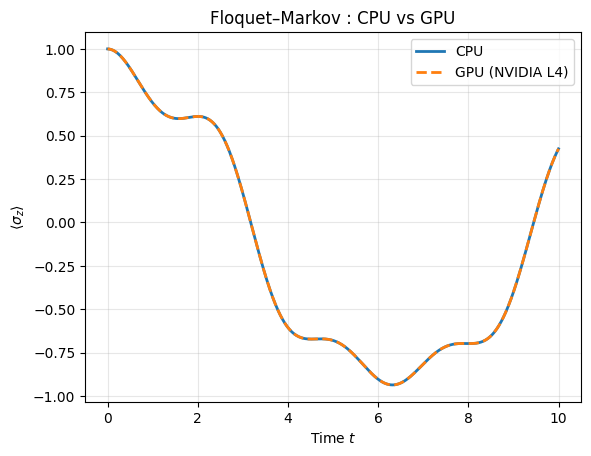

CPU runtime :    0.329 s
GPU runtime :    0.317 s   (NVIDIA L4)
‖σ_z(GPU) − σ_z(CPU)‖_∞ = 0.0


In [18]:
# -----------------------------------------------------------
# Floquet–Markov benchmark  (CPU  vs  optional CuPy GPU)
# -----------------------------------------------------------
import time, numpy as np, matplotlib.pyplot as plt, qutip
from qutip import sigmam                    # assumes H_t, psi0, tlist, e_ops

# ---------- portable import (QuTiP 5 ↔ 4) ------------------
try:
    from qutip.solver.floquet import fmmesolve
except ModuleNotFoundError:
    from qutip.floquet import fmmesolve

# ---------- Ohmic spectral density -------------------------
α, ω_c = 0.05, 10.0
def J_ohmic(w, alpha=α, w_c=ω_c):
    w = np.asarray(w)
    return alpha * w * np.exp(-w / w_c) * (w > 0)

# ---------- version-safe backend switcher ------------------
def _set_backend(backend="numpy"):
    backend = backend.lower()
    if backend not in {"numpy", "cupy"}:
        raise ValueError("backend must be 'numpy' or 'cupy'")
    try:                                   # QuTiP ≤ 4.7
        import qutip.settings as qs
        qs.DATA_LAYER = backend
        return
    except Exception:
        pass
    if backend == "numpy":                 # QuTiP ≥ 5
        qutip.settings.core["default_dtype"] = None
    else:
        import qutip_cupy                 # registers 'cupyd'
        qutip.settings.core["default_dtype"] = "cupyd"

# ---------- wrapper for timing & ⟨σ_z⟩(t) ------------------
def run_fmmesolve(backend="numpy"):
    _set_backend(backend)
    t0 = time.perf_counter()
    res = fmmesolve(
        H_t, psi0, tlist,
        c_ops=[sigmam()],
        spectra_cb=[J_ohmic],
        e_ops=e_ops,
        args={"omega": ω_d},               # ‹NEW› pass drive freq
        options={"progress_bar": False},   # suppress banner
    )
    dt = time.perf_counter() - t0
    sz = np.asarray(res.expect[0])         # shape (len(tlist),)
    return dt, sz

# ---------- CPU run ----------------------------------------
t_cpu, sz_cpu = run_fmmesolve("numpy")

# ---------- GPU run (if available) -------------------------
try:
    import cupy
    gpu_name = cupy.cuda.runtime.getDeviceProperties(0)['name'].decode()
    t_gpu, sz_gpu = run_fmmesolve("cupy")  # uses same args dict
except Exception:
    gpu_name = "Unavailable"
    t_gpu, sz_gpu = t_cpu, sz_cpu

# ---------- plot & report ----------------------------------
plt.plot(tlist, sz_cpu, label="CPU", lw=2)
plt.plot(tlist, sz_gpu, "--", label=f"GPU ({gpu_name})", lw=2)
plt.xlabel("Time $t$")
plt.ylabel(r"$\langle\sigma_z\rangle$")
plt.title("Floquet–Markov : CPU vs GPU")
plt.legend();  plt.grid(alpha=0.3);  plt.show()

print(f"CPU runtime : {t_cpu:8.3f} s")
print(f"GPU runtime : {t_gpu:8.3f} s   ({gpu_name})")
print("‖σ_z(GPU) − σ_z(CPU)‖_∞ =", np.max(np.abs(sz_gpu - sz_cpu)))
